In [34]:
# imports

import PreprocessData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random

## Regression Class

* Objective function (MSE) is defined as:

> $J(\theta) = \frac{1}{2} \sum \limits _{j=1} ^{m} (\hat{y}^{j} - y^{j}) ^ 2 $

* "fit" function definition is empty in Regression class and will be filled later in each of ClosedForm & GradientDescent.

* In "report" function, $\theta$s and MSE of each data-test and data-train is reported.

In [2]:
class Regression():
    def __init__(self):
        self.theta = None           # ndarray(n,1)
           
    def mse_with_input(self, X, y): 
        '''
        X is ndarray(m,n)
        y is ndarray(m,)            **attention: like exactly dataset.y_train
        '''
        y = np.array([y]).T
        y_pred = self.predict(X)
        return np.sum(np.square(y_pred - y))/2
    
    def mse(self, y_pred, y): 
        '''
        y_pred & y are ndarray(m,1)
        '''
        return np.sum(np.square(y_pred - y))/2
    
    def predict(self, X):
        '''
        X is ndarray(m,n)
        output is ndarray(m,1)
        '''
        return np.matmul(X, self.theta)
    
    def fit(self, x_train, y_train , eps=1e-7): 
        '''
        y_train is ndarray (m,)          **attention: like exactly dataset.y_train
        we change its dimention in this function to ndarray (m,1)
        
        output: self.theta
        '''
        # must fill self.theta                  
        pass
    
    def plot(self, X, y, X_with_one, title ,label=None): 
        '''
        X is ndarray(m,n)           -> without vector-x0
        y is ndarray(m,)            **attention: like exactly dataset.y_train
        '''      
        plt.figure()
        plt.scatter(X, np.array([y]).T)
        plt.plot(X, self.predict(X_with_one), '-r', label=label)   
        plt.legend(title=title)
        plt.show()
        return
           
    def report(self, x_train, y_train, x_test, y_test):
        '''
        x_train is ndarray(m,n)
        y_train is ndarray(m,)           **attention: like exactly dataset.y_train
        x_test is ndarray(m,n)
        y_test is ndarray(m,)            **attention: like exactly dataset.y_train
        '''
        for i in range(len(self.theta)):
            print('theta_',i, ': ', self.theta[i][0])
        
        print('MSE on train: ',self.mse_with_input(x_train, y_train))
        print('MSE on test: ',self.mse_with_input(x_test, y_test))
        return
        

## Closed-Form Class

* We are going to implement linear regression model using closed-form solution.
This class inherits from Regression class define above.

* In this method, we define objective function $J(\theta)$ as below:

> $J(\theta) = \frac{1}{2} \sum \limits _{j=1} ^{m} (h_{\theta}(X^{j}) - y^{j}) ^ 2 $

* While $h_{\theta}(X^{j})$ to predict $\hat{y}$ is defined as:

> $h_{\theta}(X^{j}) = \hat{y} = X^{j}\theta = \sum \limits _{i=0} ^{n} X^{j}_{i}\theta_{i}$

* Since we want to find $arg_{min}\theta$, means the $\theta$ which minimizes above objective function, we compute the derivative of $J(\theta)$ and find $\theta$ when it is equal to zero.

> $\nabla J(\theta) = 0$
>
> $\nabla \frac{1}{2} (X\theta - y)^{T}(X\theta - y) = 0$

* $\theta$ is calculated as:
 
> $\theta = (X^{T}X)^{-1}X^{T}y$


In [6]:
class ClosedForm(Regression):
    def __init__(self):
        super().__init__()
    
    def fit(self, x_train, y_train):
        # implementation of closed-form formula
        XT = np.transpose(x_train)
        XTX = np.matmul(XT, x_train)
        XTX_inv = np.linalg.inv(XTX)
        XTX_inv_XT = np.matmul(XTX_inv, XT)
        self.theta = np.matmul(XTX_inv_XT, y_train).reshape(len(x_train[0]), 1)

        return self.theta
    

## Closed Form Report

### Using "scale between 0 & 1" normalization

In [33]:
dataset = PreprocessData.Dataset('Data-Train.csv', 'Data-Test.csv', 'y', normalization_method='scale_0_1')
# dataset = PreprocessData.Dataset('Data-Train.csv', 'Data-Test.csv', 'y', normalization_method='zero_mean_unit_var')
# dataset = PreprocessData.Dataset('Data-Train.csv', 'Data-Test.csv', 'y', normalization_method='none')

closed_form = ClosedForm()
closed_form.fit(dataset.x_train, dataset.y_train)

closed_form.predict(dataset.x_test)

closed_form.report(dataset.x_train, dataset.y_train, dataset.x_test, dataset.y_test)

scaling to [0, 1] normalization.
theta_ 0 :  -0.21953583859344494
theta_ 1 :  100.48368423780022
MSE on train:  4164.006185786953
MSE on test:  1394.3540142796764


## Closed Form Plot

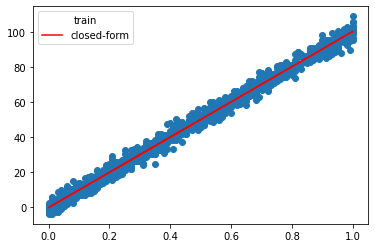

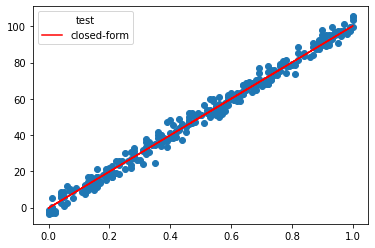

In [24]:
closed_form.plot(dataset.x_train_without_x0, dataset.y_train, dataset.x_train, 'train' , label='closed-form')

closed_form.plot(dataset.x_test_without_x0, dataset.y_test, dataset.x_test, 'test' , label='closed-form')

## Gradient Descent Class

Closed form solution might be extremely expensive to compute. Also, it is generally used if it is possible.
In those linear regression problems where a closed-form solution exists forexample least square error, it may be impractical to use the formula. e.g. X is a very large sparse matrix which will require a large space to store matrix. 
 
Gradient descent is used to minimize objective(or cost) function by repetitively moving in the direction of steepest descent in each epoch (epoch means pass over the training dataset).
Here we implement __Batch Gradient Descent__.
* The objective function is same as the previous method.
> $J(\theta) = \frac{1}{2} \sum \limits _{j=1} ^{m} (h_{\theta}(X^{j}) - y^{j}) ^ 2 $
* This method updates $\theta$ after each iteration based on below:
> $ \theta_i = \theta_i - \alpha \frac{\partial}{\partial \theta_i} J(\theta) $

* So we must calculate gradient ($ \frac{\partial}{\partial \theta_i} J(\theta) $) :
> $ \frac{\partial}{\partial \theta_i} J(\theta) = \frac{\partial}{\partial \theta_i} \sum \limits _{j=1} ^{m} \frac{1}{2} (h_\theta(X^j) - y^j)^2$ 
>
> $ \space\space\space\space\space\space\space\space\space\space\space\space = \sum \limits _{j=1} ^{m} (h_\theta(X^j) - y^j) x_i^j$

* Finally 
> $ \theta_i = \theta_i - \alpha \sum \limits _{j=1} ^{m} (h_\theta(X^j) - y^j) x_i^j $

In [16]:
class BGD(Regression):
    def __init__(self, alpha = 0.001, max_iter = 1000):
        self.alpha = alpha
        self.max_iter = max_iter
        self.cost = None
        super().__init__()
    
    
    def fit(self, x_train, y_train, eps = 1e-8):
        self.x_train = x_train
        self.y_train = np.array([y_train]).T    #change to ndarray(m,1)
        
        n = self.x_train.shape[1]               #number of features
        m = self.x_train.shape[0]               #number of samples

        self.theta = np.random.rand(n,1)        #initial random theta
        
        self.cost = []
        
        for i in range(self.max_iter):
            y_hat = self.predict(self.x_train)
            
            self.theta -= self.alpha*(np.matmul(self.x_train.T, (y_hat - self.y_train)))
            
            self.cost.append(self.mse(y_hat, self.y_train))
            diff = abs(self.mse(y_hat , self.y_train) - self.mse(self.predict(self.x_train) , self.y_train))
            if diff <= eps:
                print('Iteration', i, 'with difference', diff, 'converged.')
                break
        return self.theta
    
    def get_cost(self):
        return self.cost
    
    def plot_cost(self):
        plt.figure()
        plt.plot(self.cost, label='cost')
        plt.show()
        return 


## Batch Gradient Descent Report

### Using "scale between 0 & 1" normalization

In [17]:
dataset = PreprocessData.Dataset('Data-Train.csv', 'Data-Test.csv', 'y', normalization_method='scale_0_1')

bgd= BGD(alpha=1e-3, max_iter=4000) 

bgd.fit(dataset.x_train, dataset.y_train)

bgd.predict(dataset.x_test)

bgd.report(dataset.x_train, dataset.y_train, dataset.x_test, dataset.y_test)

scaling to [0, 1] normalization.
Iteration 214 with difference 9.349605534225702e-09 converged.
theta_ 0 :  -0.21951473193669307
theta_ 1 :  100.48364499416822
MSE on train:  4164.0061858517
MSE on test:  1394.3548388953022


## Batch Gradient Descent Plot

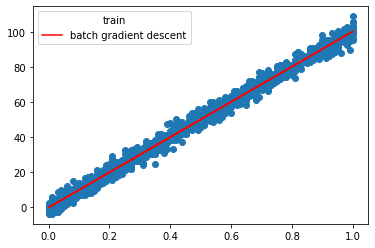

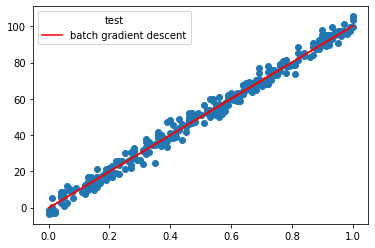

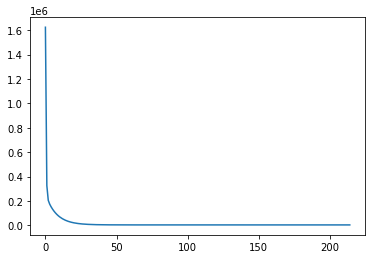

In [18]:
bgd.plot(dataset.x_train_without_x0, dataset.y_train, dataset.x_train, 'train' , label='batch gradient descent')

bgd.plot(dataset.x_test_without_x0, dataset.y_test, dataset.x_test, 'test' , label='batch gradient descent')

bgd.plot_cost()

In [20]:
print(bgd.get_cost()[0])

print(bgd.get_cost()[-1])

1624382.320921904
4164.00618586105
